# ImageNet - Bayesian Optimization 
## 02463 Active ML and Agency - Group BO 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms

import skopt
from skopt import gp_minimize
import json

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

# Download the CIFAR-100 dataset (train and test)
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# Create data loaders - BATCH SIZE IS SUBJECTIVE TO CHANGE 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

# Check the data
images, labels = next(iter(trainloader))

100%|██████████| 169M/169M [01:54<00:00, 1.47MB/s] 


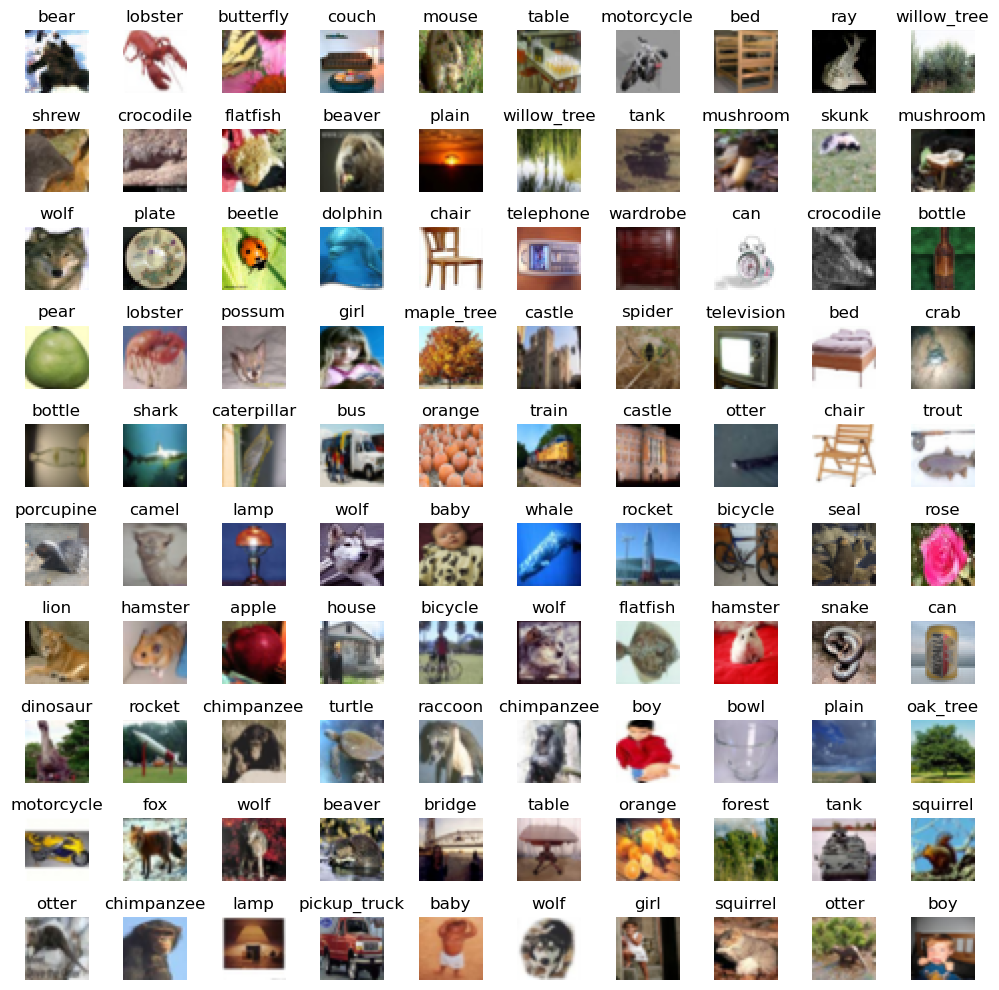

In [3]:
# Create a 10x10 subplot with random iamges and class mappings to observe our dataset

# Define the fine label names to get descriptive plots
fine_label_names = trainset.classes

fig, axs = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        idx = np.random.randint(0, 10000)
        img, label = trainset[idx]
        img = img / 2 + 0.5
        img = img.numpy().transpose(1, 2, 0)
        axs[i, j].imshow(img)
        axs[i, j].set_title(fine_label_names[label])
        axs[i, j].axis('off')
plt.tight_layout()
plt.show()

In [5]:
from train_model import train_model

params = {
    'module__base_channels': 16,                    # or try: 32
    'module__dropout': 0.5,                        # or try: 0.3
}
# Train for 10 epochs using 1000 training samples (adjust as needed)
accuracy = train_model(params, num_epochs=10, n_training_samples=1000)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/02463/lib/python3.13/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 5.1 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 17.1 K | train
---------

Epoch 9: 100%|██████████| 32/32 [00:00<00:00, 224.89it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 32/32 [00:00<00:00, 223.50it/s]
Test Accuracy: 3.95%


In [31]:


# Define the search space as follows
# params = {
#     'module__base_channels': (1,128)
#     'module__dropout': (0.0, 0.9)
# }

space = [
    skopt.space.Integer(1, 128, name='module__base_channels'),
    # skopt.space.Real(0.0, 0.9, name='module__dropout')
]

def objective(x):
    # Decode the JSON encoded categorical values.
    params = {
        'module__base_channels': x[0],
        # 'module__dropout': x[1] ,
    }
    
    accuracy = train_model(params, num_epochs=10, n_training_samples=10000)
    # Return negative accuracy for minimization.
    return -accuracy

opt_bo = gp_minimize(
    objective,
    space,
    acq_func='EI',
    n_calls=20,
    n_random_starts=5,
    verbose=True,
    xi=0.1,
    noise=0.01**2
)


Iteration No: 1 started. Evaluating function at random point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/advance_DL_CV/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 19.4 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 190 K  | train
---------------------------------------------------------
209 K     Trainable params
0         Non-trainable params
209 K     Total params
0.839     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 84/84 [00:01<00:00, 62.32it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 84/84 [00:01<00:00, 62.23it/s]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 15.1981
Function value obtained: -0.0879
Current minimum: -0.0879
Iteration No: 2 started. Evaluating function at random point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 19.4 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 84.6 K | train
---------------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.416     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 250/250 [00:02<00:00, 119.52it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 250/250 [00:02<00:00, 119.40it/s]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 25.1387
Function value obtained: -0.1809
Current minimum: -0.1809
Iteration No: 3 started. Evaluating function at random point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 93.2 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 117 K  | train
---------------------------------------------------------
210 K     Trainable params
0         Non-trainable params
210 K     Total params
0.842     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 106/106 [00:01<00:00, 94.20it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 106/106 [00:01<00:00, 94.02it/s]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 14.7575
Function value obtained: -0.1103
Current minimum: -0.1809
Iteration No: 4 started. Evaluating function at random point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 19.4 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 190 K  | train
---------------------------------------------------------
209 K     Trainable params
0         Non-trainable params
209 K     Total params
0.839     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 129/129 [00:01<00:00, 101.58it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 129/129 [00:01<00:00, 101.43it/s]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 15.8887
Function value obtained: -0.0466
Current minimum: -0.1809
Iteration No: 5 started. Evaluating function at random point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 93.2 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 117 K  | train
---------------------------------------------------------
210 K     Trainable params
0         Non-trainable params
210 K     Total params
0.842     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 110/110 [00:01<00:00, 89.68it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 110/110 [00:01<00:00, 89.50it/s]
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 15.8150
Function value obtained: -0.0100
Current minimum: -0.1809
Iteration No: 6 started. Searching for the next optimal point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/advance_DL_CV/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 19.4 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 84.6 K | train
---------------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.416     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 205/205 [00:01<00:00, 114.47it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 205/205 [00:01<00:00, 114.31it/s]
Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 21.5973
Function value obtained: -0.1840
Current minimum: -0.1840
Iteration No: 7 started. Searching for the next optimal point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/advance_DL_CV/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 93.2 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 223 K  | train
---------------------------------------------------------
316 K     Trainable params
0         Non-trainable params
316 K     Total params
1.265     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 81/81 [00:01<00:00, 72.67it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 81/81 [00:01<00:00, 72.55it/s]
Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 14.1526
Function value obtained: -0.1343
Current minimum: -0.1840
Iteration No: 8 started. Searching for the next optimal point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/advance_DL_CV/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 19.4 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 190 K  | train
---------------------------------------------------------
209 K     Trainable params
0         Non-trainable params
209 K     Total params
0.839     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 79/79 [00:01<00:00, 71.27it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 79/79 [00:01<00:00, 71.12it/s]
Iteration No: 8 ended. Search finished for the next optimal point.
Time taken: 14.1726
Function value obtained: -0.0913
Current minimum: -0.1840
Iteration No: 9 started. Searching for the next optimal point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/advance_DL_CV/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 19.4 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 190 K  | train
---------------------------------------------------------
209 K     Trainable params
0         Non-trainable params
209 K     Total params
0.839     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 218/218 [00:01<00:00, 112.77it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 218/218 [00:01<00:00, 112.64it/s]
Iteration No: 9 ended. Search finished for the next optimal point.
Time taken: 22.3372
Function value obtained: -0.0100
Current minimum: -0.1840
Iteration No: 10 started. Searching for the next optimal point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/advance_DL_CV/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 19.4 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 84.6 K | train
---------------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.416     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 141/141 [00:01<00:00, 104.72it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 141/141 [00:01<00:00, 104.54it/s]
Iteration No: 10 ended. Search finished for the next optimal point.
Time taken: 16.1273
Function value obtained: -0.0643
Current minimum: -0.1840
Iteration No: 11 started. Searching for the next optimal point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/advance_DL_CV/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 19.4 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 190 K  | train
---------------------------------------------------------
209 K     Trainable params
0         Non-trainable params
209 K     Total params
0.839     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 304/304 [00:02<00:00, 102.55it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 304/304 [00:02<00:00, 102.48it/s]
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 31.2345
Function value obtained: -0.0921
Current minimum: -0.1840
Iteration No: 12 started. Searching for the next optimal point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/advance_DL_CV/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 19.4 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 84.6 K | train
---------------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.416     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 79/79 [00:01<00:00, 72.89it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 79/79 [00:01<00:00, 72.75it/s]
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 14.5945
Function value obtained: -0.0100
Current minimum: -0.1840
Iteration No: 13 started. Searching for the next optimal point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/advance_DL_CV/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 19.4 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 190 K  | train
---------------------------------------------------------
209 K     Trainable params
0         Non-trainable params
209 K     Total params
0.839     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 81/81 [00:01<00:00, 73.29it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 81/81 [00:01<00:00, 73.17it/s]
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 14.1151
Function value obtained: -0.1240
Current minimum: -0.1840
Iteration No: 14 started. Searching for the next optimal point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/advance_DL_CV/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 19.4 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 84.6 K | train
---------------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.416     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 304/304 [00:02<00:00, 123.83it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 304/304 [00:02<00:00, 123.72it/s]
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 29.7728
Function value obtained: -0.1464
Current minimum: -0.1840
Iteration No: 15 started. Searching for the next optimal point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/advance_DL_CV/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 93.2 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 117 K  | train
---------------------------------------------------------
210 K     Trainable params
0         Non-trainable params
210 K     Total params
0.842     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 313/313 [00:02<00:00, 116.69it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 313/313 [00:02<00:00, 116.59it/s]
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 30.0704
Function value obtained: -0.0100
Current minimum: -0.1840
Iteration No: 16 started. Searching for the next optimal point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/advance_DL_CV/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 93.2 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 117 K  | train
---------------------------------------------------------
210 K     Trainable params
0         Non-trainable params
210 K     Total params
0.842     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 173/173 [00:01<00:00, 100.01it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 173/173 [00:01<00:00, 99.90it/s] 
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 20.9478
Function value obtained: -0.1636
Current minimum: -0.1840
Iteration No: 17 started. Searching for the next optimal point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/advance_DL_CV/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 93.2 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 117 K  | train
---------------------------------------------------------
210 K     Trainable params
0         Non-trainable params
210 K     Total params
0.842     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 271/271 [00:02<00:00, 114.91it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 271/271 [00:02<00:00, 114.81it/s]
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 27.1453
Function value obtained: -0.1172
Current minimum: -0.1840
Iteration No: 18 started. Searching for the next optimal point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/advance_DL_CV/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 19.4 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 84.6 K | train
---------------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.416     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 80/80 [00:01<00:00, 71.83it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 80/80 [00:01<00:00, 71.71it/s]
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 14.6418
Function value obtained: -0.1495
Current minimum: -0.1840
Iteration No: 19 started. Searching for the next optimal point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/advance_DL_CV/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 19.4 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 190 K  | train
---------------------------------------------------------
209 K     Trainable params
0         Non-trainable params
209 K     Total params
0.839     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 193/193 [00:01<00:00, 113.39it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 193/193 [00:01<00:00, 113.22it/s]
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 20.3136
Function value obtained: -0.0451
Current minimum: -0.1840
Iteration No: 20 started. Searching for the next optimal point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/advance_DL_CV/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 93.2 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 223 K  | train
---------------------------------------------------------
316 K     Trainable params
0         Non-trainable params
316 K     Total params
1.265     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 295/295 [00:02<00:00, 112.02it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 295/295 [00:02<00:00, 111.94it/s]
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 30.9290
Function value obtained: -0.1338
Current minimum: -0.1840


In [32]:
# do random search
from skopt import dummy_minimize
opt_random = dummy_minimize(
    objective,
    space,
    n_calls=20,
    verbose=True,
    random_state=42
)


Iteration No: 1 started. Evaluating function at random point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/ubuntu/miniconda3/envs/advance_DL_CV/lib/python3.11/site-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 93.2 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 117 K  | train
---------------------------------------------------------
210 K     Trainable params
0         Non-trainable params
210 K     Total params
0.842     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 134/134 [00:01<00:00, 96.19it/s] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 134/134 [00:01<00:00, 96.01it/s]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 17.4190
Function value obtained: -0.0100
Current minimum: -0.0100
Iteration No: 2 started. Evaluating function at random point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 19.4 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 84.6 K | train
---------------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.416     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 107/107 [00:01<00:00, 82.76it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 107/107 [00:01<00:00, 82.61it/s]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 15.0760
Function value obtained: -0.0909
Current minimum: -0.0909
Iteration No: 3 started. Evaluating function at random point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 19.4 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 190 K  | train
---------------------------------------------------------
209 K     Trainable params
0         Non-trainable params
209 K     Total params
0.839     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 79/79 [00:01<00:00, 73.30it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 79/79 [00:01<00:00, 73.15it/s]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 14.4335
Function value obtained: -0.0363
Current minimum: -0.0909
Iteration No: 4 started. Evaluating function at random point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 93.2 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 223 K  | train
---------------------------------------------------------
316 K     Trainable params
0         Non-trainable params
316 K     Total params
1.265     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 122/122 [00:01<00:00, 99.28it/s] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 122/122 [00:01<00:00, 99.09it/s]
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 15.3321
Function value obtained: -0.0779
Current minimum: -0.0909
Iteration No: 5 started. Evaluating function at random point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 19.4 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 84.6 K | train
---------------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.416     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 244/244 [00:02<00:00, 108.95it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 244/244 [00:02<00:00, 108.84it/s]
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 27.8233
Function value obtained: -0.1172
Current minimum: -0.1172
Iteration No: 6 started. Evaluating function at random point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 93.2 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 117 K  | train
---------------------------------------------------------
210 K     Trainable params
0         Non-trainable params
210 K     Total params
0.842     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 87/87 [00:01<00:00, 77.22it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 87/87 [00:01<00:00, 77.09it/s]
Iteration No: 6 ended. Evaluation done at random point.
Time taken: 14.5227
Function value obtained: -0.1517
Current minimum: -0.1517
Iteration No: 7 started. Evaluating function at random point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 93.2 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 117 K  | train
---------------------------------------------------------
210 K     Trainable params
0         Non-trainable params
210 K     Total params
0.842     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 117/117 [00:01<00:00, 83.23it/s] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 117/117 [00:01<00:00, 83.11it/s]
Iteration No: 7 ended. Evaluation done at random point.
Time taken: 15.6758
Function value obtained: -0.0100
Current minimum: -0.1517
Iteration No: 8 started. Evaluating function at random point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 19.4 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 84.6 K | train
---------------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.416     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 103/103 [00:01<00:00, 87.66it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 103/103 [00:01<00:00, 87.51it/s]
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 14.8903
Function value obtained: -0.1121
Current minimum: -0.1517
Iteration No: 9 started. Evaluating function at random point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 93.2 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 223 K  | train
---------------------------------------------------------
316 K     Trainable params
0         Non-trainable params
316 K     Total params
1.265     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 205/205 [00:01<00:00, 106.23it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 205/205 [00:01<00:00, 106.12it/s]
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 22.3994
Function value obtained: -0.1621
Current minimum: -0.1621
Iteration No: 10 started. Evaluating function at random point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 93.2 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 117 K  | train
---------------------------------------------------------
210 K     Trainable params
0         Non-trainable params
210 K     Total params
0.842     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 286/286 [00:02<00:00, 114.11it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 286/286 [00:02<00:00, 114.01it/s]
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 29.0362
Function value obtained: -0.0795
Current minimum: -0.1621
Iteration No: 11 started. Evaluating function at random point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 93.2 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 117 K  | train
---------------------------------------------------------
210 K     Trainable params
0         Non-trainable params
210 K     Total params
0.842     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 99/99 [00:01<00:00, 87.34it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 99/99 [00:01<00:00, 87.15it/s]
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 14.2867
Function value obtained: -0.0100
Current minimum: -0.1621
Iteration No: 12 started. Evaluating function at random point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 19.4 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 190 K  | train
---------------------------------------------------------
209 K     Trainable params
0         Non-trainable params
209 K     Total params
0.839     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 89/89 [00:01<00:00, 80.17it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 89/89 [00:01<00:00, 79.99it/s]
Iteration No: 12 ended. Evaluation done at random point.
Time taken: 14.3415
Function value obtained: -0.0100
Current minimum: -0.1621
Iteration No: 13 started. Evaluating function at random point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 93.2 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 223 K  | train
---------------------------------------------------------
316 K     Trainable params
0         Non-trainable params
316 K     Total params
1.265     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 112/112 [00:01<00:00, 81.47it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 112/112 [00:01<00:00, 81.34it/s]
Iteration No: 13 ended. Evaluation done at random point.
Time taken: 15.9799
Function value obtained: -0.0100
Current minimum: -0.1621
Iteration No: 14 started. Evaluating function at random point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 19.4 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 84.6 K | train
---------------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.416     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 137/137 [00:01<00:00, 106.18it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 137/137 [00:01<00:00, 106.00it/s]
Iteration No: 14 ended. Evaluation done at random point.
Time taken: 18.1341
Function value obtained: -0.0663
Current minimum: -0.1621
Iteration No: 15 started. Evaluating function at random point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 19.4 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 84.6 K | train
---------------------------------------------------------
103 K     Trainable params
0         Non-trainable params
103 K     Total params
0.416     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 74.08it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 100/100 [00:01<00:00, 73.98it/s]
Iteration No: 15 ended. Evaluation done at random point.
Time taken: 15.1370
Function value obtained: -0.1039
Current minimum: -0.1621
Iteration No: 16 started. Evaluating function at random point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 93.2 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 223 K  | train
---------------------------------------------------------
316 K     Trainable params
0         Non-trainable params
316 K     Total params
1.265     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 84/84 [00:01<00:00, 74.64it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 84/84 [00:01<00:00, 74.52it/s]
Iteration No: 16 ended. Evaluation done at random point.
Time taken: 14.3963
Function value obtained: -0.0239
Current minimum: -0.1621
Iteration No: 17 started. Evaluating function at random point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 93.2 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 117 K  | train
---------------------------------------------------------
210 K     Trainable params
0         Non-trainable params
210 K     Total params
0.842     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 105/105 [00:01<00:00, 86.09it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 105/105 [00:01<00:00, 85.93it/s]
Iteration No: 17 ended. Evaluation done at random point.
Time taken: 15.0068
Function value obtained: -0.1896
Current minimum: -0.1896
Iteration No: 18 started. Evaluating function at random point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 93.2 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 223 K  | train
---------------------------------------------------------
316 K     Trainable params
0         Non-trainable params
316 K     Total params
1.265     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 145/145 [00:01<00:00, 80.19it/s] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 145/145 [00:01<00:00, 80.09it/s]
Iteration No: 18 ended. Evaluation done at random point.
Time taken: 18.3810
Function value obtained: -0.0100
Current minimum: -0.1896
Iteration No: 19 started. Evaluating function at random point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 93.2 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 223 K  | train
---------------------------------------------------------
316 K     Trainable params
0         Non-trainable params
316 K     Total params
1.265     Total estimated model params size (MB)
19        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 176/176 [00:01<00:00, 104.30it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 176/176 [00:01<00:00, 104.17it/s]
Iteration No: 19 ended. Evaluation done at random point.
Time taken: 19.5694
Function value obtained: -0.1136
Current minimum: -0.1896
Iteration No: 20 started. Evaluating function at random point.
Files already downloaded and verified
Files already downloaded and verified


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 19.4 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 190 K  | train
---------------------------------------------------------
209 K     Trainable params
0         Non-trainable params
209 K     Total params
0.839     Total estimated model params size (MB)
16        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 197/197 [00:01<00:00, 103.60it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 197/197 [00:01<00:00, 103.50it/s]
Iteration No: 20 ended. Evaluation done at random point.
Time taken: 20.9564
Function value obtained: -0.1454
Current minimum: -0.1896


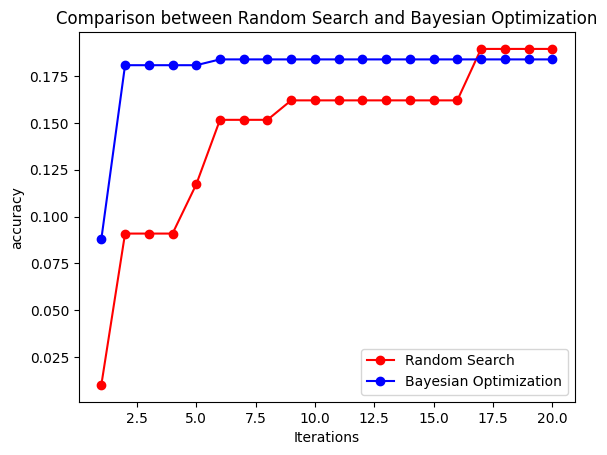

In [33]:
## comparison between random search and bayesian optimization
## we can plot the maximum oob per iteration of the sequence

# collect the maximum each iteration of BO
y_bo = np.maximum.accumulate(-opt_bo.func_vals).ravel()
y_random = np.maximum.accumulate(-opt_random.func_vals).ravel()
# define iteration number
xs = range(1, len(y_bo) + 1)

plt.plot(xs, y_random, 'o-', color = 'red', label='Random Search')
plt.plot(xs, y_bo, 'o-', color = 'blue', label='Bayesian Optimization')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('accuracy')
plt.title('Comparison between Random Search and Bayesian Optimization')
plt.show()